In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --no-index scikit-learn
!pip install --no-index seaborn
!pip install --no-index optuna

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/scikit_learn-1.5.2+computecanada-cp311-cp311-linux_x86_64.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/threadpoolctl-3.5.0+computecanada-py3-none-any.whl (from scikit-learn)
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/seaborn-0.13.2+computecanada-py3-none-any.whl
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/p

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from glob import glob
import os
import re
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms
import random


from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

# Train ResNet Classifier on whole generated_dataset

## First we need to load that datset

In [4]:
class Muti1320SequenceDataset(Dataset):
    def __init__(self, image_path, transform=None, val_dataset: bool = False):
        self.image_path = image_path
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        if val_dataset:
            self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
        # Sort image files
        self.images = sort_filenames(glob(os.path.join(image_path, "*.png")))
        
        # Load metadata
        meta_data_path = os.path.join(image_path, "working_memory_images_labels.csv")
        self.meta_data = pd.read_csv(meta_data_path)
        self.meta_data["img_path"] = self.images
        
        # Create a mapping of unique objects to integer labels
        self.label_to_idx = {obj: i for i, obj in enumerate(self.meta_data["object"].unique())}
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Create sequence: first frame is the original image, rest are grayscale
        if self.transform:
            image = self.transform(image)        
        
        label = self.meta_data.loc[self.meta_data["img_path"] == img_path, "object"].values[0]
        label_idx = self.label_to_idx[label]
        
        return image, label_idx
    
    def hvm200_to_coco1600(self, label):
        hvm200_to_coco1600 = {
            "bear": "bear",
            "elephant": "ELEPHANT_M",
            "person": "face0001",
            "car": "alfa155",
            "dog": "breed_pug",
            "apple": "Apple_Fruit_obj",
            "chair": "_001",
            "plane": "f16",
            "bird": "lo_poly_animal_CHICKDEE",
            "zebra": "zebra"
        }
        return hvm200_to_coco1600.get(label, label)

def extract_number(filename):
    # Extract the number from the filename
    match = re.search(r'im(\d+)\.png', filename)
    if match:
        return int(match.group(1))
    return 0  # Return 0 if no number is found

def sort_filenames(filenames):
    # Sort the filenames based on the extracted number
    return sorted(filenames, key=extract_number)

def read_and_extract_indices(file_path):
    try:
        # Read the file
        with open(file_path, 'r') as file:
            content = file.read()
            
        # Extract indices
        test_indices = []
        for line in content.split('\n'):
            if line.strip():  # Skip empty lines
                # Extract the number between [ and ,
                number = line.split('[')[1].split(',')[0]
                test_indices.append(int(number))
                
        return test_indices
        
    except FileNotFoundError:
        print(f"File not found at path: {file_path}")
        return None
    except IOError:
        print(f"Error reading file at path: {file_path}")
        return None

def visualize_random_samples(dataset, num_samples=5, figsize=(15, 3)):
    """
    Visualize random samples from the dataset.
    
    Args:
        dataset: Instance of Muti1320SequenceDataset
        num_samples: Number of random samples to display
        figsize: Size of the figure (width, height)
    """
    # Create figure
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    # Get random indices
    dataset_size = len(dataset)
    random_indices = random.sample(range(dataset_size), num_samples)
    
    # Inverse label mapping
    idx_to_label = {v: k for k, v in dataset.label_to_idx.items()}
    
    # Plot each sample
    for i, idx in enumerate(random_indices):
        # Get image and label
        image, label_idx = dataset[idx]
        
        # Convert tensor to numpy for plotting
        if torch.is_tensor(image):
            image = image.numpy()
        
        # Transpose if necessary (C,H,W) -> (H,W,C)
        if image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))
            
        # Clip values to [0, 1] range
        image = np.clip(image, 0, 1)
        
        # Get original label
        label = idx_to_label[label_idx]
        
        # Plot
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f'Label: {label}')
    
    plt.tight_layout()
    return fig

def visualize_class_samples(dataset, class_name, num_samples=5, figsize=(15, 3)):
    """
    Visualize samples from a specific class in the dataset.
    
    Args:
        dataset: Instance of Muti1320SequenceDataset
        class_name: Name of the class to visualize
        num_samples: Number of samples to display
        figsize: Size of the figure (width, height)
    """
    # Get class index
    class_idx = dataset.label_to_idx[class_name]
    
    # Find all indices for this class
    class_indices = []
    for idx in range(len(dataset)):
        _, label_idx = dataset[idx]
        if label_idx == class_idx:
            class_indices.append(idx)
    
    # Select random samples from this class
    selected_indices = random.sample(class_indices, min(num_samples, len(class_indices)))
    
    # Create figure
    fig, axes = plt.subplots(1, len(selected_indices), figsize=figsize)
    
    # Plot each sample
    for i, idx in enumerate(selected_indices):
        # Get image
        image, _ = dataset[idx]
        
        # Convert tensor to numpy for plotting
        if torch.is_tensor(image):
            image = image.numpy()
        
        # Transpose if necessary (C,H,W) -> (H,W,C)
        if image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))
            
        # Clip values to [0, 1] range
        image = np.clip(image, 0, 1)
        
        # Plot
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i+1}')
    
    plt.suptitle(f'Class: {class_name}')
    plt.tight_layout()
    return fig

In [5]:
# Example usage:
transform = transforms.Compose([
       transforms.Resize((224, 224)),
       transforms.RandomHorizontalFlip(),
       transforms.RandomRotation(15),
       transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
       transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
       transforms.ToTensor(),
       transforms.Grayscale(3),
       transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
   ])

image_path = "../../data/muri1320/"
batch_size = 32
dataset = Muti1320SequenceDataset(image_path, transform=transform)

# Split dataset while preserving label distribution
match_idx_path = "../../data/muri1320/matching_indices.txt"
indices = range(len(dataset))
val_indices = read_and_extract_indices(match_idx_path)
train_indices = sorted(list(set(indices) - set(val_indices)))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

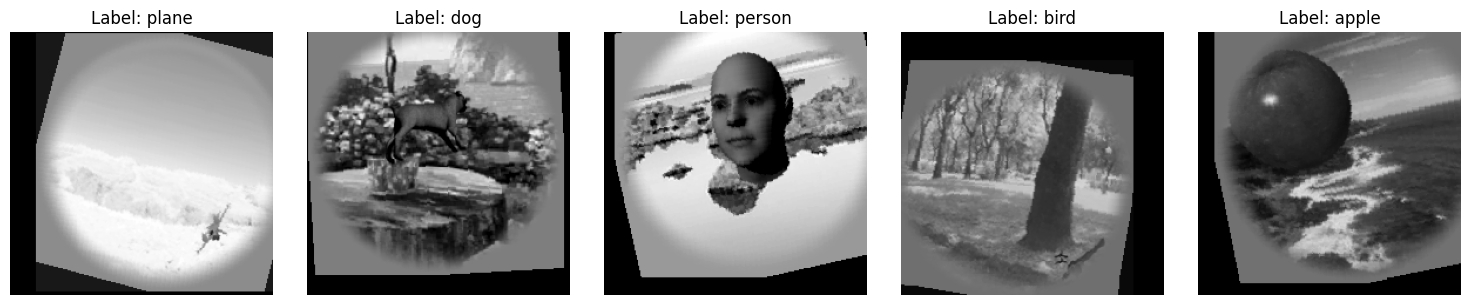

In [6]:
# Visualize random samples
fig = visualize_random_samples(dataset, num_samples=5)
plt.show()

# Visualize samples from a specific class (e.g., "bear")
# fig = visualize_class_samples(dataset, class_name="bear", num_samples=5)
# plt.show()

## train resnet50

In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
import optuna
import pandas as pd
import json

from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime


class ObjectiveTrainer:
    def __init__(self, train_loader, val_loader, num_classes=10, base_save_dir='hyperparameter_tuning'):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.num_classes = num_classes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Create directories for saving results
        self.base_save_dir = base_save_dir
        self.models_dir = os.path.join(base_save_dir, 'models')
        os.makedirs(self.models_dir, exist_ok=True)
        
        # Initialize results tracking
        self.results_file = os.path.join(base_save_dir, 'tuning_results.csv')
        if not os.path.exists(self.results_file):
            pd.DataFrame(columns=[
                'trial_number', 'val_accuracy', 'learning_rate', 'weight_decay',
                'optimizer', 'scheduler_factor', 'scheduler_patience',
                'label_smoothing', 'batch_norm_unfreeze', 'layer4_unfreeze',
                'model_path', 'best_epoch'
            ]).to_csv(self.results_file, index=False)

    def create_model(self, trial):
        model = resnet50(pretrained=True)
        
        # Freeze all layers initially
        for param in model.parameters():
            param.requires_grad = False
            
        # Optionally unfreeze BatchNorm layers
        if trial.suggest_categorical('batch_norm_unfreeze', [True, False]):
            for module in model.modules():
                if isinstance(module, nn.BatchNorm2d):
                    for param in module.parameters():
                        param.requires_grad = True
                        
        # Optionally unfreeze layer4
        if trial.suggest_categorical('layer4_unfreeze', [True, False]):
            for param in model.layer4.parameters():
                param.requires_grad = True
        
        # Replace the classifier
        model.fc = nn.Linear(model.fc.in_features, self.num_classes)
        return model.to(self.device)

    def __call__(self, trial):
        # Model creation
        model = self.create_model(trial)
        
        # Hyperparameters
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
        label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.2)
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW'])
        scheduler_factor = trial.suggest_float('scheduler_factor', 0.1, 0.5)
        scheduler_patience = trial.suggest_int('scheduler_patience', 3, 7)
        
        # Loss and optimizer setup
        criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        optimizer_class = getattr(torch.optim, optimizer_name)
        optimizer = optimizer_class(model.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=scheduler_factor,
            patience=scheduler_patience, min_lr=1e-6
        )
        
        # Training loop
        best_val_acc = 0
        best_epoch = 0
        early_stop_counter = 0
        max_epochs = 50
        
        for epoch in range(max_epochs):
            # Training
            model.train()
            train_loss = 0
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            # Validation
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in self.val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            val_acc = 100 * correct / total
            scheduler.step(val_loss)
            
            # Update best accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch
                early_stop_counter = 0
                
                # Save the best model for this trial
                model_filename = f'model_trial_{trial.number}_acc_{val_acc:.2f}.pth'
                model_path = os.path.join(self.models_dir, model_filename)
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'val_accuracy': val_acc,
                    'hyperparameters': {
                        'learning_rate': learning_rate,
                        'weight_decay': weight_decay,
                        'optimizer': optimizer_name,
                        'scheduler_factor': scheduler_factor,
                        'scheduler_patience': scheduler_patience,
                        'label_smoothing': label_smoothing,
                        'batch_norm_unfreeze': trial.params['batch_norm_unfreeze'],
                        'layer4_unfreeze': trial.params['layer4_unfreeze']
                    }
                }, model_path)
            else:
                early_stop_counter += 1
            
            # Early stopping
            if early_stop_counter >= 10:
                break
            
            # Report intermediate results
            trial.report(val_acc, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        # Save results to CSV
        results_df = pd.read_csv(self.results_file)
        new_result = pd.DataFrame([{
            'trial_number': trial.number,
            'val_accuracy': best_val_acc,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'optimizer': optimizer_name,
            'scheduler_factor': scheduler_factor,
            'scheduler_patience': scheduler_patience,
            'label_smoothing': label_smoothing,
            'batch_norm_unfreeze': trial.params['batch_norm_unfreeze'],
            'layer4_unfreeze': trial.params['layer4_unfreeze'],
            'model_path': model_filename,
            'best_epoch': best_epoch
        }])
        results_df = pd.concat([results_df, new_result], ignore_index=True)
        results_df.to_csv(self.results_file, index=False)
        
        return best_val_acc

def run_hyperparameter_tuning(train_loader, val_loader, n_trials=50):
    study_name = f"resnet50_tuning_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    study = optuna.create_study(
        study_name=study_name,
        direction="maximize",
        pruner=optuna.pruners.MedianPruner()
    )
    
    trainer = ObjectiveTrainer(train_loader, val_loader)
    study.optimize(trainer, n_trials=n_trials)
    
    # Print best results
    print("Best trial:")
    print(f"  Value: {study.best_trial.value:.2f}% validation accuracy")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    
    # Save study results
    study_results = {
        'best_params': study.best_trial.params,
        'best_value': study.best_trial.value,
        'n_trials': n_trials,
        'study_name': study_name
    }
    
    with open(os.path.join(trainer.base_save_dir, 'study_results.json'), 'w') as f:
        json.dump(study_results, f, indent=4)
    
    return study

In [ ]:
# Run the hyperparameter tuning
study = run_hyperparameter_tuning(train_loader, val_loader, n_trials=50)

[I 2024-11-19 17:11:03,130] A new study created in memory with name: resnet50_tuning_20241119_171103
/localscratch/soroush1.37052318.0/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/localscratch/soroush1.37052318.0/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_713844/70778235.py:169: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determ

# Test trained ResNet on 200 images, while we're adding a ODE decay factor to model's output

In [9]:
def create_model(num_classes, device, weights_path=None):
    # Initialize model with pretrained weights
    model = models.resnet50(weights=None)
    
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
        
    # Replace final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # Load custom weights if provided
    if weights_path:
        ckpt = torch.load(weights_path, map_location=device)
        model.load_state_dict(ckpt["model_state_dict"])
    
    return model.to(device)

# Initialize parameters
weights_path = "hyperparameter_tuning/models/model_trial_4_acc_71.00.pth"
num_classes = 10  # Your number of classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(num_classes=num_classes, device=device, weights_path=weights_path)

train, val = get_graph_node_names(model)
val

['x',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.relu_1',
 'layer1.0.conv3',
 'layer1.0.bn3',
 'layer1.0.downsample.0',
 'layer1.0.downsample.1',
 'layer1.0.add',
 'layer1.0.relu_2',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.relu_1',
 'layer1.1.conv3',
 'layer1.1.bn3',
 'layer1.1.add',
 'layer1.1.relu_2',
 'layer1.2.conv1',
 'layer1.2.bn1',
 'layer1.2.relu',
 'layer1.2.conv2',
 'layer1.2.bn2',
 'layer1.2.relu_1',
 'layer1.2.conv3',
 'layer1.2.bn3',
 'layer1.2.add',
 'layer1.2.relu_2',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.relu_1',
 'layer2.0.conv3',
 'layer2.0.bn3',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.0.add',
 'layer2.0.relu_2',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.bn2',
 'layer2.1.relu_1',
 'layer2.


Plot saved to: combined_decay_rates.png


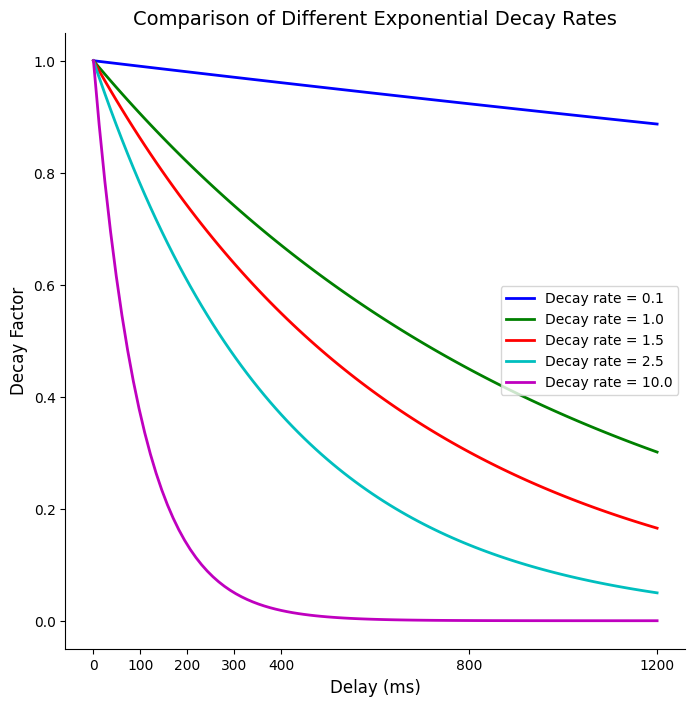


Decay values at key timepoints:

Decay rate = 0.1
At 0ms: 1.000
At 100ms: 0.990
At 200ms: 0.980
At 300ms: 0.970
At 400ms: 0.961
At 800ms: 0.923
At 1200ms: 0.887

Decay rate = 1.0
At 0ms: 1.000
At 100ms: 0.905
At 200ms: 0.819
At 300ms: 0.741
At 400ms: 0.670
At 800ms: 0.449
At 1200ms: 0.301

Decay rate = 1.5
At 0ms: 1.000
At 100ms: 0.861
At 200ms: 0.741
At 300ms: 0.638
At 400ms: 0.549
At 800ms: 0.301
At 1200ms: 0.165

Decay rate = 2.5
At 0ms: 1.000
At 100ms: 0.779
At 200ms: 0.607
At 300ms: 0.472
At 400ms: 0.368
At 800ms: 0.135
At 1200ms: 0.050

Decay rate = 10.0
At 0ms: 1.000
At 100ms: 0.368
At 200ms: 0.135
At 300ms: 0.050
At 400ms: 0.018
At 800ms: 0.000
At 1200ms: 0.000


In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
import numpy as np
import time

class ExponentialDecayLayer(nn.Module):
    def __init__(self, decay_rate=0.1, delay_ms=400):
        super(ExponentialDecayLayer, self).__init__()
        self.decay_rate = torch.tensor(decay_rate)
        self.delay_ms = delay_ms
        
    def forward(self, x):
        # Convert delay_ms to seconds and apply final decay value
        t = torch.tensor(self.delay_ms / 1000.0)  # convert to seconds
        decay = torch.exp(-self.decay_rate * t)
        print(f"Applying decay factor: {decay.item():.3f} for delay {self.delay_ms}ms")
        return x * decay

def plot_multiple_decay_curves(decay_rates, max_delay_ms=1200, num_points=100, save_path=None):
    """
    Plot multiple decay curves with different decay rates on the same plot.
    
    Args:
        decay_rates (list): List of decay rates to plot
        max_delay_ms (int): Maximum delay in milliseconds
        num_points (int): Number of points to plot
        save_path (str or Path, optional): Path to save the plot image
    """
    # Define a color palette
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    times = np.linspace(0, max_delay_ms, num_points)
    
    # Create square figure
    plt.figure(figsize=(8, 8))
    
    # Plot each decay rate with a different color
    for i, decay_rate in enumerate(decay_rates):
        decay_values = np.exp(-decay_rate * (times / 1000.0))
        color = colors[i % len(colors)]  # Cycle through colors if more decay rates than colors
        plt.plot(times, decay_values, color=color, linestyle='-', 
                label=f'Decay rate = {decay_rate:.1f}', linewidth=2)
    
    plt.xlabel('Delay (ms)', fontsize=12)
    plt.ylabel('Decay Factor', fontsize=12)
    plt.title('Comparison of Different Exponential Decay Rates', fontsize=14)
    plt.grid(False)  # Turn off grid
    plt.legend(fontsize=10)
    
    # Add key timepoints markers
    key_times = [0, 100, 200, 300, 400, 800, 1200]
    plt.xticks(key_times, labels=key_times, fontsize=10)
    
    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved to: {save_path}")
    
    plt.show()
    
    # Print decay values at key timepoints for each rate
    print("\nDecay values at key timepoints:")
    for decay_rate in decay_rates:
        print(f"\nDecay rate = {decay_rate:.1f}")
        for t in key_times:
            decay = np.exp(-decay_rate * (t / 1000.0))
            print(f"At {t}ms: {decay:.3f}")

# Example usage with multiple decay rates
decay_rates = [0.1, 1.0, 1.5, 2.5, 10.0]
plot_multiple_decay_curves(decay_rates, save_path="combined_decay_rates.png")

In [11]:
def extract_number(filename):
    # Extract the number from the filename
    match = re.search(r'im(\d+)\.png', filename)
    if match:
        return int(match.group(1))
    return 0  # Return 0 if no number is found

def sort_filenames(filenames):
    # Sort the filenames based on the extracted number
    return sorted(filenames, key=extract_number)

class HVM200SequenceDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.num_timesteps = num_timesteps
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
        # Sort image files
        self.images = sort_filenames(glob(os.path.join(image_path, "*.png")))
        
        # Load metadata
        meta_data_path = os.path.join(image_path, "working_memory_images_labels.csv")
        self.meta_data = pd.read_csv(meta_data_path)
        self.meta_data["img_path"] = self.images
        
        # Create a mapping of unique objects to integer labels
        self.label_to_idx = {obj: i for i, obj in enumerate(self.meta_data["object"].unique())}
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        
        label = self.meta_data.loc[self.meta_data["img_path"] == img_path, "object"].values[0]
        label_idx = self.label_to_idx[label]
        
        return image, label_idx
    
    def hvm200_to_coco1600(self, label):
        hvm200_to_coco1600 = {
            "bear": "bear",
            "elephant": "ELEPHANT_M",
            "person": "face0001",
            "car": "alfa155",
            "dog": "breed_pug",
            "apple": "Apple_Fruit_obj",
            "chair": "_001",
            "plane": "f16",
            "bird": "lo_poly_animal_CHICKDEE",
            "zebra": "zebra"
        }
        return hvm200_to_coco1600.get(label, label)

# Usage example:
image_path = "../hypothesis_wm_experiments/data/hvm200/"

num_timesteps = 4  # 100ms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(3),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

dataset = HVM200SequenceDataset(image_path, transform=transform)
img, label = dataset[0]
img.shape

torch.Size([3, 224, 224])

In [16]:
class FeatureExtractor(nn.Module):
    def __init__(self, decay_rate=0.1, delay_ms=400):
        super(FeatureExtractor, self).__init__()
        
        self.base_model = self._create_model()
        self.feature_extractor = create_feature_extractor(
            self.base_model, 
            return_nodes={
                "fc": "pre_decay",
            }
        )
        
        self.decay = ExponentialDecayLayer(decay_rate=decay_rate, delay_ms=delay_ms)

    def _create_model(self):
        def create_model(num_classes, device, weights_path=None):
            # Initialize model with pretrained weights
            model = models.resnet50(weights=None)
            
            # Freeze all layers initially
            for param in model.parameters():
                param.requires_grad = False
                
            # Replace final fully connected layer
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            
            # Load custom weights if provided
            if weights_path:
                ckpt = torch.load(weights_path, map_location=device)
                model.load_state_dict(ckpt["model_state_dict"])
            
            return model.to(device)

        # Initialize parameters
        weights_path = "hyperparameter_tuning/models/model_trial_4_acc_71.00.pth"
        num_classes = 10  # Your number of classes
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return create_model(num_classes=num_classes, device=device, weights_path=weights_path)
        
        
    def forward(self, x):
        # Get features before decay
        features = self.feature_extractor(x)
        pre_decay_features = features["pre_decay"]
        print(f"{pre_decay_features.size() = }")
        
        # Apply decay
        post_decay_features = self.decay(pre_decay_features)
        
        return pre_decay_features, post_decay_features


def extract_features(dataset, model, device, batch_size=32):
    """Extract features for all images in the dataset"""
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    pre_decay_features = []
    post_decay_features = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            pre_decay, post_decay = model(batch_imgs)
            
            pre_decay_features.append(pre_decay.cpu())
            post_decay_features.append(post_decay.cpu())
            labels.append(batch_labels)
            
    pre_decay_features = torch.cat(pre_decay_features, dim=0)
    post_decay_features = torch.cat(post_decay_features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return pre_decay_features, post_decay_features, labels

In [29]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset parameters
image_path = "../hypothesis_wm_experiments/data/hvm200/"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(3),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

# Create dataset
dataset = HVM200SequenceDataset(image_path, transform=transform)
# Create model for different delays
delays = [0, 100, 400, 800, 1200]  # milliseconds
decay_rate = 2


# Dictionary to store features
all_features = {}

for delay in delays:
    print(f"\nExtracting features for {delay}ms delay...")
    
    # Create model
    model = FeatureExtractor(decay_rate=decay_rate, delay_ms=delay)
    model = model.to(device)
    model.eval()
    
    # Extract features
    pre_decay, post_decay, labels = extract_features(dataset, model, device)
    
    # Store features
    all_features[delay] = {
        'pre_decay': pre_decay,
        'post_decay': post_decay,
        'labels': labels
    }
    
    print(f"Extracted features shapes:")
    print(f"Pre-decay: {pre_decay.shape}")
    print(f"Post-decay: {post_decay.shape}")
    
    # Save features
    save_dir = f"extracted_features_fc_layer/{decay_rate}decay"
    os.makedirs(save_dir, exist_ok=True)
    
    torch.save({
        'pre_decay': pre_decay,
        'post_decay': post_decay,
        'labels': labels,
        'decay_rate': decay_rate,
        'delay_ms': delay
    }, os.path.join(save_dir, f'features_delay{delay}ms.pt'))
    
    # Calculate average decay effect
    decay_effect = (post_decay / (pre_decay + 1e-6)).mean().item()
    print(f"Average decay factor: {decay_effect:.3f}")

    


Extracting features for 0ms delay...
pre_decay_features.size() = torch.Size([32, 10])
Applying decay factor: 1.000 for delay 0ms
pre_decay_features.size() = torch.Size([32, 10])
Applying decay factor: 1.000 for delay 0ms
pre_decay_features.size() = torch.Size([32, 10])
Applying decay factor: 1.000 for delay 0ms
pre_decay_features.size() = torch.Size([32, 10])
Applying decay factor: 1.000 for delay 0ms
pre_decay_features.size() = torch.Size([32, 10])
Applying decay factor: 1.000 for delay 0ms
pre_decay_features.size() = torch.Size([32, 10])
Applying decay factor: 1.000 for delay 0ms
pre_decay_features.size() = torch.Size([8, 10])
Applying decay factor: 1.000 for delay 0ms
Extracted features shapes:
Pre-decay: torch.Size([200, 10])
Post-decay: torch.Size([200, 10])
Average decay factor: 1.000

Extracting features for 100ms delay...
pre_decay_features.size() = torch.Size([32, 10])
Applying decay factor: 0.819 for delay 100ms
pre_decay_features.size() = torch.Size([32, 10])
Applying decay